In [ ]:
import pandas as pd

sent_path = "/content/news_label_daily_sentiment_scores.csv"
df = pd.read_csv(sent_path)
df['Date'] = pd.to_datetime(df['Date'])

price_path = "/content/upload_DJIA_table.csv"
price_df = pd.read_csv(price_path)
price_df['Date'] = pd.to_datetime(price_df['Date'])

price_df = price_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]

df = pd.merge(df, price_df, on='Date', how='inner')

df = df.sort_values('Date').reset_index(drop=True)

df.head()


,Date,sentiment_score,Label,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0.68,0,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,1.04,1,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,0.92,0,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,0.64,0,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,0.88,1,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [ ]:
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date').reset_index(drop=True)

input = sentiment_score for N consecutive days <br>
(N = 7 [score(t-6), ..., score(t)]) <br>

output y = the next day (t+1)'s DJIA label <br>

In [ ]:
import numpy as np

window_size = 5  # N

feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'sentiment_score']

features = df[feature_cols].values

labels = df['Label'].values

X_list = []
y_list = []

# [i, i+window_size-1]
for i in range(len(df) - window_size):
    x_window = features[i : i + window_size]

    x_flat = x_window.reshape(-1)

    y_target = labels[i + window_size]

    X_list.append(x_flat)
    y_list.append(y_target)

X = np.array(X_list)
y = np.array(y_list)
print(X.shape, y.shape)

(1984, 35) (1984,)


train / val / test <br>
70% / 15% / 15%

In [ ]:
num_samples = X.shape[0]

train_end = int(num_samples * 0.7)
val_end   = int(num_samples * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1388, 35) Val: (298, 35) Test: (298, 35)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SentimentSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # for CrossEntropyLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentSeqDataset(X_train_scaled, y_train)
val_dataset   = SentimentSeqDataset(X_val_scaled, y_val)
test_dataset  = SentimentSeqDataset(X_test_scaled, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

input_dim = X_train_scaled.shape[1]

class MLPBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPBaseline(input_dim=input_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total


num_epochs = 30

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 0.6981 Acc: 0.5058 | Val Loss: 0.7067 Acc: 0.5537
Epoch 02 | Train Loss: 0.6907 Acc: 0.5317 | Val Loss: 0.6829 Acc: 0.5604
Epoch 03 | Train Loss: 0.6901 Acc: 0.5252 | Val Loss: 0.6870 Acc: 0.5570
Epoch 04 | Train Loss: 0.6876 Acc: 0.5367 | Val Loss: 0.6841 Acc: 0.5839
Epoch 05 | Train Loss: 0.6873 Acc: 0.5519 | Val Loss: 0.6824 Acc: 0.5872
Epoch 06 | Train Loss: 0.6870 Acc: 0.5418 | Val Loss: 0.6830 Acc: 0.5671
Epoch 07 | Train Loss: 0.6865 Acc: 0.5403 | Val Loss: 0.6822 Acc: 0.6040
Epoch 08 | Train Loss: 0.6858 Acc: 0.5562 | Val Loss: 0.6842 Acc: 0.5906
Epoch 09 | Train Loss: 0.6856 Acc: 0.5526 | Val Loss: 0.6819 Acc: 0.5805
Epoch 10 | Train Loss: 0.6831 Acc: 0.5692 | Val Loss: 0.6827 Acc: 0.5671
Epoch 11 | Train Loss: 0.6824 Acc: 0.5605 | Val Loss: 0.6844 Acc: 0.5604
Epoch 12 | Train Loss: 0.6810 Acc: 0.5591 | Val Loss: 0.6934 Acc: 0.4765
Epoch 13 | Train Loss: 0.6832 Acc: 0.5447 | Val Loss: 0.6912 Acc: 0.5134
Epoch 14 | Train Loss: 0.6831 Acc: 0.5670 | Val Los

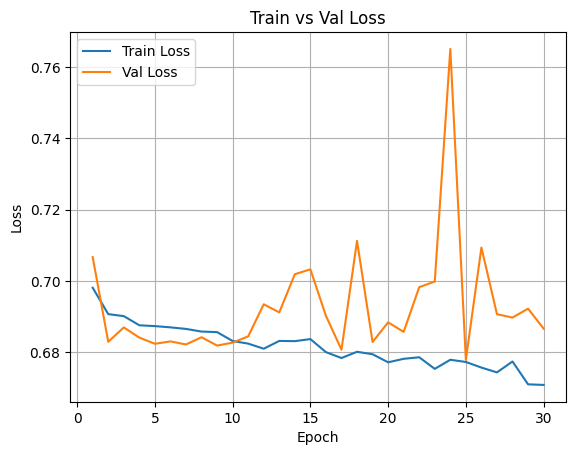

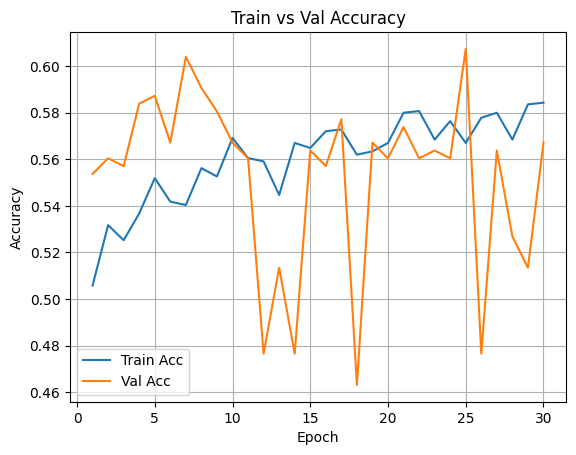

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import numpy as np

model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(y_batch.numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# predicted class
y_pred = all_logits.argmax(axis=1)

test_acc = accuracy_score(all_labels, y_pred)
cm = confusion_matrix(all_labels, y_pred, labels=[0,1])

# ROC-AUC (for binary)
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
positive_probs = probs[:, 1]  # class 1
test_auc = roc_auc_score(all_labels, positive_probs)

print("Test Accuracy:", test_acc)
print("Test ROC-AUC:", test_auc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, y_pred))

Test Accuracy: 0.48322147651006714
Test ROC-AUC: 0.4814614587556877
Confusion Matrix:
 [[55 92]
 [62 89]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.37      0.42       147
           1       0.49      0.59      0.54       151

    accuracy                           0.48       298
   macro avg       0.48      0.48      0.48       298
weighted avg       0.48      0.48      0.48       298



In [ ]:
majority_class = np.bincount(y_train).argmax()
baseline_pred = np.full_like(all_labels, fill_value=majority_class)
baseline_acc = accuracy_score(all_labels, baseline_pred)
print("Majority Baseline Accuracy:", baseline_acc)

Majority Baseline Accuracy: 0.5067114093959731
